# **LSTM model for sentiment analysis**

## Import modules and packages
Import all the necessary modules and packages necessary to build, train, and evaluate the model. Also, set random seeds so that the program can be run for multiple seeds to check how variant the model's performance is.

In [1]:
!pip install -r requirements.txt

import collections,os,random,time
import matplotlib.pyplot as plt
import numpy as np
import datasets

import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.utils.data import Dataset
import torchtext
import torchtext.data as ttd
import torchtext.vocab as ttv

#Set the environment time
os.environ['TZ']='US/Central'
time.tzset()

#Set the seed
sd=random.randint(0,50)
np.random.seed(sd)
torch.manual_seed(sd)
torch.cuda.manual_seed(sd)
torch.backends.cudnn.deterministic=True

#Print current time
print('\n\nProgram execution started on: {}'.format(time.ctime()))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

## IMDb dataset
The IMDb dataset from HuggingFace will be used for model development.

### Define the dataset
Download the 'train' and 'test' splits of the dataset, and inspect its characteristics.

In [2]:
#Download the 'train' and the 'test' splits of the IMDb dataset
trSet,tsSet=datasets.load_dataset('imdb',split=['train','test'])
print('The respective sizes of the training and the testing datasets are {} and {} respectively. \nThe sentiment class labels are {}.'.format(trSet.num_rows,tsSet.num_rows,trSet.features['label']))
print('A sample picked from any dataset would look as shown below:\n\n{}'.format(trSet[0]))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

The respective sizes of the training and the testing datasets are 25000 and 25000 respectively. 
The sentiment class labels are ClassLabel(names=['neg', 'pos'], id=None).
A sample picked from any dataset would look as shown below:

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on po

### Tokenization
Convert the datasets from collections of strings to collections of numbers so that it is possible for any machine learning model to process them.

In [3]:
#The function that tokenizes the dataset
def tokenize(dataset,tokenizer,maxLength):
  tokens=tokenizer(dataset['text'])[:maxLength]
  length=len(tokens)
  return {'tokens':tokens,'lengths':length}

#Define the tokenizer and perform tokenization
maxLength=256       #maximum length of each token
tokenizer=ttd.utils.get_tokenizer('basic_english')
print('Tokenizing the training dataset...')
trSet=trSet.map(tokenize,fn_kwargs={'tokenizer':tokenizer,'maxLength':maxLength})
print('Tokenizing the testing dataset...')
tsSet=tsSet.map(tokenize,fn_kwargs={'tokenizer':tokenizer,'maxLength':maxLength})
print('\nThe contents of the tokenized datasets are as follows:\n{}'.format(trSet))
print('\n\nA sample from the tokenized dataset would look as shown below:\n\n1. Text:\n{}'.format(trSet[0]['text']))
print('\n2. Label:\n{}'.format(trSet[0]['label']))
print('\n3. Tokens:\n{}'.format(trSet[0]['tokens']))
print('\n4. Tokens:\n{}'.format(trSet[0]['lengths']))

Tokenizing the training dataset...


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Tokenizing the testing dataset...


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]


The contents of the tokenized datasets are as follows:
Dataset({
    features: ['text', 'label', 'tokens', 'lengths'],
    num_rows: 25000
})


A sample from the tokenized dataset would look as shown below:

1. Text:
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with

### Validation dataset
Set aside a portion of the tokenized training dataset as the validation dataset.

In [4]:
valRatio=0.25
tempSet=trSet.train_test_split(test_size=valRatio)
trSet=tempSet['train']
valSet=tempSet['test']
print('The respective final sizes of the training, the validation, and the testing datasets are:{}, {}, and {} respectively.'.format(len(trSet),len(valSet),len(tsSet)))

The respective final sizes of the training, the validation, and the testing datasets are:18750, 6250, and 25000 respectively.


### Vocabulary
Convert the tokens into one-hot representations by defining a minimum threshold frequency of occurence for each token and the unknown and the padding tokens.

In [5]:
#Define the vocabulary
threshold=5                 #minimum frequency of occurence for a token to be assigned a one-hot representation
spclTokens=['<unk>','<pad>']#to represent tokens with frequency<threshold and for padding to make all sentences have the same lengths
vocabulary=ttv.build_vocab_from_iterator(trSet['tokens'],min_freq=threshold,specials=spclTokens)
print('The number of tokens in the vocabulary is {}.'.format(len(vocabulary)))##tokens forming the vocabulary after eliminating tokens with frequency<'threshold'

#Indices of the special tokens in the vocabulary
idxUnk,idxPad=vocabulary['<unk>'],vocabulary['<pad>']
vocabulary.set_default_index(idxUnk)#set '<unk>' as the default token for any new words encounterd. Otherwise, new words will raise an error

The number of tokens in the vocabulary is 21528.


### Numerize the vocabulary
Convert the tokens into a numerical format so that they can be processed by neural networks.

In [6]:
#The function that numerizes the tokenized dataset
def numerize(dataset,vocabulary):
  indices=vocabulary.lookup_indices(dataset['tokens'])
  return {'indices':indices}

#Numerize the datasets
print('Numerizing the training dataset...')
trSet=trSet.map(numerize,fn_kwargs={'vocabulary':vocabulary})
print('Numerizing the validation dataset...')
valSet=valSet.map(numerize,fn_kwargs={'vocabulary':vocabulary})
print('Numerizing the testing dataset...')
tsSet=tsSet.map(numerize,fn_kwargs={'vocabulary':vocabulary})
print('The contents of the numerized datasets are as follows:\n{}.'.format(trSet))
print('\n\nA sample from the numerized dataset would look as shown below:\n\n1. Text:\n{}'.format(trSet[0]['text']))
print('\n2. Label:\n{}'.format(trSet[0]['label']))
print('\n3. Tokens:\n{}'.format(trSet[0]['tokens']))
print('\n4. Length:\n{}'.format(trSet[0]['lengths']))
print('\n5. Indices:\n{}'.format(trSet[0]['indices']))

#Convert the datasets to tensors after retaining only 'label' and 'indices'
trSet=trSet.with_format(type='torch',columns=['indices','label','lengths'])
valSet=valSet.with_format(type='torch',columns=['indices','label','lengths'])
trSet=tsSet.with_format(type='torch',columns=['indices','label','lengths'])
print('\nThe numerized datasets\' contents after their conversion to tensors are as follows:\n{}.'.format(trSet))
print('\n\nA sample from a dataset tensor would look as shown below:\n\n1. Label:\n{}'.format(trSet[0]['label']))
print('\n2. Length:\n{}'.format(trSet[0]['lengths']))
print('\n3. Indices:\n{}'.format(trSet[0]['indices']))

Numerizing the training dataset...


Map:   0%|          | 0/18750 [00:00<?, ? examples/s]

Numerizing the validation dataset...


Map:   0%|          | 0/6250 [00:00<?, ? examples/s]

Numerizing the testing dataset...


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

The contents of the numerized datasets are as follows:
Dataset({
    features: ['text', 'label', 'tokens', 'lengths', 'indices'],
    num_rows: 18750
}).


A sample from the numerized dataset would look as shown below:

1. Text:
Ella was excellent, Franchot was unavoidably over-the-top (But he played similar parts in other films such as "The Man on the Eiffel Tower") and Alan was nearly non-existent but the film certainly "thrilled".<br /><br />*mild spoiler ahead*: I wonder how many times Elisha Cook got strangled in his films but I seem to recall various other examples. I will avoid naming the murderer but I think it's necessarily obvious because of the plot "thriller" demands.<br /><br />A very well-done but dated film noire (for example: everyone smoked like crazy and the police were really stock characters. And no dead bodies were ever shown, unlike today's gore fests.) done in the familiar short-scene tableaux format of the period.<br /><br />8 out of 10.

2. Label:
1

3. Tokens:

### Data loader

In [7]:
#The class prepares batches of data that can be iterated over by the data loader.
#The batch is prepared by collating a group of data samples in the function
#'collate'. The function also pads the shorter sequences in the batch with '<pad>'
#to make their lengths equal to that of the batch's longest sequence. This
#ensures that the neural network model's I/P dimension remains fixed.
class sentimentDataset(Dataset):
  def __init__(self,dataset,batchSize,idxPad,shuffle=False):
    self.dataset,self.batchSize=dataset,batchSize
    self.idxPad=idxPad
    self.shuffle=shuffle

  def collate(self,batch):
    batchLabels=[sample['label'] for sample in batch]
    batchLengths=[sample['lengths'] for sample in batch]
    batchIndices=[sample['indices'] for sample in batch]
    batchLabels=torch.stack(batchLabels)
    batchLengths=torch.stack(batchLengths)
    batchIndices=nn.utils.rnn.pad_sequence(batchIndices,padding_value=self.idxPad,batch_first=True)
    print('Batch size is {} and {}.'.format(batchLabels.shape,batchLengths.shape,batchIndices.shape))
    return {'label':batchLabels,'lengths':batchLengths,'indices':batchIndices}

  def loadData(self):
    dataLoader=torch.utils.data.DataLoader(dataset=self.dataset,batch_size=self.batchSize,collate_fn=self.collate,shuffle=self.shuffle)
    return dataLoader

def dataIterators(set,dataset,params):
  if set=='train':obj=sentimentDataset(dataset,params['batchSize'],params['padIndex'],shuffle=True)
  elif set=='validate':obj=sentimentDataset(dataset,params['batchSize'],params['padIndex'],shuffle=False)
  elif set=='test':obj=sentimentDataset(dataset,params['batchSize'],params['padIndex'],shuffle=False)
  return obj.loadData()

## LSTM model for sentiment classification
The sentiment classification model will be an LSTM with an architecture as defined below:

In [8]:
class lstm(nn.Module):
  #Initializes the LSTM class
  def __init__(self,vocabularySize,embDim,hiddenDim,opDim,L,bi,rate,idxPad):
    super(lstm,self).__init__()
    self.embed=nn.Embedding(vocabularySize,embDim,padding_idx=idxPad)
    self.lstm=nn.LSTM(embDim,hiddenDim,L,bidirectional=bi,dropout=rate,batch_first=True)
    self.linear=nn.Linear(hiddenDim*2 if bi else hiddenDim,opDim)
    self.dropout=nn.Dropout(rate)

  #Forward propagates a batch of IDs (denoted by 'x') of size
  #[batchSize,sequenceLength] and  lengths (denoted by 'lengths') of size
  #[batchSize] through the network
  def forward(self,x,lengths):
    x1=self.dropout(self.embed(x))                    #size is [batchSize,sequenceLength,embDim]
    packedEmbedded=nn.utils.rnn.pack_padded_sequence(x1,lengths,batch_first=True,enforce_sorted=False)#pack zero-padded batch of samples for computational efficiency
    #Output sizes of the LSTM layer are:
    #1. 'packedOP': O/P for all time-steps with size [batchSize,sequenceLength,hiddenDim*nDim], where 'nDim'=2 for bidirectional and 1 otherwise
    #2. #h: O/P for the last time-step with size [L*nDim,batchSize,hiddenDim]
    #3. #c: cell-state for the last time-step with size [L*nDim,batchSize,hiddenDim]
    packedOP,(h,c)=self.lstm(packedEmbedded)
    OP,lnOP=nn.utils.rnn.pad_packed_sequence(packedOP)#inverse operation of packing; OP's size is [batchSize,sequenceLength,hiddenDim*nDim]
    if self.lstm.bidirectional:
      h=self.dropout(torch.cat([h[-1],h[-2]],dim=-1)) #size is [batchSize,hiddenDim*2]; 'nDim'=2 since bidirectional
    else:
      h=self.dropout(h[-1])                           #size is [batchSize,hiddenDim]; 'nDim'=1 since unidirectional
    labelsHat=self.linear(h)
    return labelsHat                                  #prediction's size is [batchSize,opDim]

## Model training and evaluation
The functions that train, validate, and evaluate the LSTM model are defined below.

In [61]:
#This function trains and validates the model
def train(vocabulary,trDataLoader,valDataLoader,params):
  #Define the model and initialize its weights
  model=lstm(params['vocabularySize'],params['embDim'],params['hiddenDim'],params['opDim'],params['lstmLayers'],params['bi'],params['rate'],params['padIndex'])
  model.apply(initWeights)
  #Initialize embedding layer's weights with pretrained weights from Glove
  vectors=torchtext.vocab.GloVe()          #initializing embedded layer with pretrained weights from Glove
  temp=vocabulary.get_itos()               #vocabulary tokens represented as a list
  pretrainEmb=vectors.get_vecs_by_tokens(temp)
  model.embed.weight.data=pretrainEmb      #replace embedding layer's initial random weights with pretrained weights
  #Define the cost-function and the optimizer
  optimizer=optim.Adam(model.parameters(),lr=params['alpha'])
  costFun=nn.CrossEntropyLoss().to(params['device'])
  #Start training the model
  metrics=collections.defaultdict(list)
  bestValLoss=float("inf")
  earlyCounter,tolerance=0,3               #for early stopping
  model.to(params['device'])               #move the model to the GPU
  model.train()                            #configure the model for training
  for epoch in range(params['epochs']):    #loop for epochs
    model.train()                          #configure the model for training
    trLosses,trAccuracies=[],[]
    #Loop over each training batch
    for dataBatch in tqdm.tqdm(trDataLoader,desc='Model training in progress...'):
      labels=dataBatch['label'].to(params['device'])
      lengths=dataBatch['lengths']
      indices=dataBatch['indices'].to(params['device'])
      #Forward propagation
      labelsHat=model(indices,lengths)
      loss=costFun(labelsHat,labels)
      accuracy=getAccuracy(labelsHat,labels)
      #Backpropagation
      optimizer.zero_grad()                #initialize all gradients to zero
      loss.backward()
      optimizer.step()
      #Update the losses
      trLosses.append(loss.item())
      trAccuracies.append(accuracy.item())
    metrics["train_losses"].append(np.mean(trLosses))
    metrics["train_accs"].append(np.mean(trAccuracies))
    #Validate the model after each epoch
    model.eval()
    valLosses,valAccuracies=[],[]
    with torch.no_grad():                  #backpropagation not required
      for dataBatch in tqdm.tqdm(valDataLoader,desc='Model validation in progress...'):
        labels=dataBatch['label'].to(params['device'])
        lengths=dataBatch['lengths']
        indices=dataBatch['indices'].to(params['device'])
        #Forward propagation
        labelsHat=model(indices,lengths)
        loss=costFun(labelsHat,labels)
        accuracy=getAccuracy(labelsHat,labels)
        #Update the losses
        valLosses.append(loss.item())
        valAccuracies.append(accuracy.item())
    metrics["valid_losses"].append(np.mean(valLosses))
    metrics["valid_accs"].append(np.mean(valAccuracies))
    if np.mean(valLosses)<bestValLoss:
      bestValLoss=np.mean(valLosses)
      torch.save(model.state_dict(),'lstm.pt')
    print(f'Epoch: {epoch}')
    print(f'Training loss: {np.mean(trLosses):.3f},Training accuracy: {np.mean(trAccuracies):.3f}')
    print(f'Validation loss: {np.mean(valLosses):.3f},Validation accuracy: {np.mean(valAccuracies):.3f}\n\n')
    #Check if training must be stopped early
    earlyCounter=earlyStopping(earlyCounter,np.mean(trLosses),np.mean(valLosses))
    if earlyCounter>=tolerance:
      print('\n\nModel training stopping early...')
      break
  return model,costFun,metrics

#This function evaluates the model
def evaluate(model,tsDataLoader,costFun,params):
  model.eval()                           #configure the model for evaluation
  tsLosses,tsAccuracies=[],[]
  with torch.no_grad():                  #backpropagation not required
    for dataBatch in tqdm.tqdm(tsDataLoader,desc='Model evaluation in progress...'):
      labels=dataBatch['label'].to(params['device'])
      lengths=dataBatch['lengths']
      indices=dataBatch['indices'].to(params['device'])
      #Forward propagation
      labelsHat=model(indices,lengths)
      loss=costFun(labelsHat,labels)
      accuracy=getAccuracy(labelsHat,labels)
      #Update the losses
      tsLosses.append(loss.item())
      tsAccuracies.append(accuracy.item())
  return np.mean(tsLosses),np.mean(tsAccuracies)

#This function initializes the network weights
def initWeights(model):
  if isinstance(model,nn.Linear):
    nn.init.xavier_normal_(model.weight) #Xavier initialization for linear layer weights
    nn.init.zeros_(model.bias)           #initialize all bias weights to zeros
  elif isinstance(model,nn.LSTM):
    for layer,weights in model.named_parameters():
      if 'weight' in layer:
        nn.init.orthogonal_(weights)     #Orthogonal initialization for LSTM layer weights
      elif 'bias' in layer:
        nn.init.zeros_(weights)          #initialize all bias weights to zeros

#This function computes the accuracies of predictions for a given batch of data
def getAccuracy(yHat,y):
  batchSize,_=yHat.shape
  labelsHat=yHat.argmax(dim=-1)          #predicted class labels
  TP=labelsHat.eq(y).sum()               #true positives
  return TP/batchSize

#This function implements early stopping to prevent overifitting
def earlyStopping(counter,trLoss,valLoss,delta=0.1,tolerance=3):
  if (valLoss-trLoss)>delta:counter+=1
  else:counter=0
  return counter

## Main function

Model training in progress...:   0%|          | 0/49 [00:00<?, ?it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   2%|▏         | 1/49 [00:00<00:42,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   4%|▍         | 2/49 [00:01<00:39,  1.19it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   6%|▌         | 3/49 [00:02<00:38,  1.21it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   8%|▊         | 4/49 [00:03<00:36,  1.22it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  10%|█         | 5/49 [00:04<00:35,  1.23it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  12%|█▏        | 6/49 [00:04<00:34,  1.23it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  14%|█▍        | 7/49 [00:05<00:34,  1.22it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  16%|█▋        | 8/49 [00:06<00:33,  1.22it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  18%|█▊        | 9/49 [00:07<00:33,  1.21it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  20%|██        | 10/49 [00:08<00:32,  1.21it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  22%|██▏       | 11/49 [00:09<00:31,  1.21it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  24%|██▍       | 12/49 [00:09<00:30,  1.21it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  27%|██▋       | 13/49 [00:10<00:29,  1.21it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  29%|██▊       | 14/49 [00:11<00:29,  1.20it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  31%|███       | 15/49 [00:12<00:28,  1.20it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  33%|███▎      | 16/49 [00:13<00:27,  1.21it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  35%|███▍      | 17/49 [00:14<00:26,  1.19it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  37%|███▋      | 18/49 [00:14<00:25,  1.19it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  39%|███▉      | 19/49 [00:15<00:25,  1.20it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  41%|████      | 20/49 [00:16<00:24,  1.19it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  43%|████▎     | 21/49 [00:17<00:23,  1.19it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  45%|████▍     | 22/49 [00:18<00:22,  1.19it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  47%|████▋     | 23/49 [00:19<00:21,  1.18it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  49%|████▉     | 24/49 [00:19<00:21,  1.18it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  51%|█████     | 25/49 [00:20<00:20,  1.17it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  53%|█████▎    | 26/49 [00:21<00:19,  1.17it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  55%|█████▌    | 27/49 [00:22<00:18,  1.16it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  57%|█████▋    | 28/49 [00:23<00:18,  1.16it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  59%|█████▉    | 29/49 [00:24<00:17,  1.16it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  61%|██████    | 30/49 [00:25<00:16,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  63%|██████▎   | 31/49 [00:26<00:15,  1.16it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  65%|██████▌   | 32/49 [00:26<00:14,  1.16it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  67%|██████▋   | 33/49 [00:27<00:13,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  69%|██████▉   | 34/49 [00:28<00:13,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  71%|███████▏  | 35/49 [00:29<00:12,  1.16it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  73%|███████▎  | 36/49 [00:30<00:11,  1.16it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  76%|███████▌  | 37/49 [00:31<00:10,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  78%|███████▊  | 38/49 [00:32<00:09,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  80%|███████▉  | 39/49 [00:32<00:08,  1.16it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  82%|████████▏ | 40/49 [00:33<00:07,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  84%|████████▎ | 41/49 [00:34<00:06,  1.16it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  86%|████████▌ | 42/49 [00:35<00:06,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  88%|████████▊ | 43/49 [00:36<00:05,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  90%|████████▉ | 44/49 [00:37<00:04,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  92%|█████████▏| 45/49 [00:38<00:03,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  94%|█████████▍| 46/49 [00:39<00:02,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  96%|█████████▌| 47/49 [00:40<00:01,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  98%|█████████▊| 48/49 [00:40<00:00,  1.14it/s]

Batch size is torch.Size([424]) and torch.Size([424]).


Model validation in progress...:   0%|          | 0/13 [00:00<?, ?it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:   8%|▊         | 1/13 [00:00<00:03,  3.66it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  15%|█▌        | 2/13 [00:00<00:03,  3.61it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  23%|██▎       | 3/13 [00:00<00:02,  3.57it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  31%|███       | 4/13 [00:01<00:02,  3.50it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  38%|███▊      | 5/13 [00:01<00:02,  3.50it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  46%|████▌     | 6/13 [00:01<00:01,  3.55it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  54%|█████▍    | 7/13 [00:01<00:01,  3.52it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  62%|██████▏   | 8/13 [00:02<00:01,  3.51it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  69%|██████▉   | 9/13 [00:02<00:01,  3.48it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  77%|███████▋  | 10/13 [00:02<00:00,  3.52it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  85%|████████▍ | 11/13 [00:03<00:00,  3.50it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...: 100%|██████████| 13/13 [00:03<00:00,  3.72it/s]


Batch size is torch.Size([106]) and torch.Size([106]).
Epoch: 0
Training loss: 0.618,Training accuracy: 0.649
Validation loss: 0.583,Validation accuracy: 0.667




Model training in progress...:   0%|          | 0/49 [00:00<?, ?it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   2%|▏         | 1/49 [00:00<00:41,  1.17it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   4%|▍         | 2/49 [00:01<00:41,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   6%|▌         | 3/49 [00:02<00:40,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   8%|▊         | 4/49 [00:03<00:40,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  10%|█         | 5/49 [00:04<00:39,  1.11it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  12%|█▏        | 6/49 [00:05<00:38,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  14%|█▍        | 7/49 [00:06<00:37,  1.11it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  16%|█▋        | 8/49 [00:07<00:36,  1.11it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  18%|█▊        | 9/49 [00:08<00:35,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  20%|██        | 10/49 [00:08<00:35,  1.11it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  22%|██▏       | 11/49 [00:09<00:34,  1.11it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  24%|██▍       | 12/49 [00:10<00:33,  1.10it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  27%|██▋       | 13/49 [00:11<00:32,  1.10it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  29%|██▊       | 14/49 [00:12<00:31,  1.10it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  31%|███       | 15/49 [00:13<00:30,  1.11it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  33%|███▎      | 16/49 [00:14<00:29,  1.11it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  35%|███▍      | 17/49 [00:15<00:29,  1.10it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  37%|███▋      | 18/49 [00:16<00:28,  1.10it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  39%|███▉      | 19/49 [00:17<00:26,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  41%|████      | 20/49 [00:17<00:26,  1.11it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  43%|████▎     | 21/49 [00:18<00:25,  1.11it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  45%|████▍     | 22/49 [00:19<00:24,  1.11it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  47%|████▋     | 23/49 [00:20<00:23,  1.11it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  49%|████▉     | 24/49 [00:21<00:22,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  51%|█████     | 25/49 [00:22<00:21,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  53%|█████▎    | 26/49 [00:23<00:20,  1.11it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  55%|█████▌    | 27/49 [00:24<00:19,  1.11it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  57%|█████▋    | 28/49 [00:25<00:18,  1.11it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  59%|█████▉    | 29/49 [00:26<00:17,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  61%|██████    | 30/49 [00:26<00:16,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  63%|██████▎   | 31/49 [00:27<00:15,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  65%|██████▌   | 32/49 [00:28<00:15,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  67%|██████▋   | 33/49 [00:29<00:14,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  69%|██████▉   | 34/49 [00:30<00:13,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  71%|███████▏  | 35/49 [00:31<00:12,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  73%|███████▎  | 36/49 [00:32<00:11,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  76%|███████▌  | 37/49 [00:33<00:10,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  78%|███████▊  | 38/49 [00:33<00:09,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  80%|███████▉  | 39/49 [00:34<00:08,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  82%|████████▏ | 40/49 [00:35<00:07,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  84%|████████▎ | 41/49 [00:36<00:07,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  86%|████████▌ | 42/49 [00:37<00:06,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  88%|████████▊ | 43/49 [00:38<00:05,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  90%|████████▉ | 44/49 [00:39<00:04,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  92%|█████████▏| 45/49 [00:40<00:03,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  94%|█████████▍| 46/49 [00:40<00:02,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  96%|█████████▌| 47/49 [00:41<00:01,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  98%|█████████▊| 48/49 [00:42<00:00,  1.14it/s]

Batch size is torch.Size([424]) and torch.Size([424]).


Model validation in progress...:   0%|          | 0/13 [00:00<?, ?it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:   8%|▊         | 1/13 [00:00<00:03,  3.65it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  15%|█▌        | 2/13 [00:00<00:03,  3.60it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  23%|██▎       | 3/13 [00:00<00:02,  3.58it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  31%|███       | 4/13 [00:01<00:02,  3.47it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  38%|███▊      | 5/13 [00:01<00:02,  3.47it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  46%|████▌     | 6/13 [00:01<00:01,  3.52it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  54%|█████▍    | 7/13 [00:01<00:01,  3.50it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  62%|██████▏   | 8/13 [00:02<00:01,  3.48it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  69%|██████▉   | 9/13 [00:02<00:01,  3.46it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  77%|███████▋  | 10/13 [00:02<00:00,  3.53it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  85%|████████▍ | 11/13 [00:03<00:00,  3.52it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s]


Batch size is torch.Size([106]) and torch.Size([106]).
Epoch: 1
Training loss: 0.474,Training accuracy: 0.774
Validation loss: 0.523,Validation accuracy: 0.734




Model training in progress...:   0%|          | 0/49 [00:00<?, ?it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   2%|▏         | 1/49 [00:00<00:40,  1.18it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   4%|▍         | 2/49 [00:01<00:40,  1.16it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   6%|▌         | 3/49 [00:02<00:40,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   8%|▊         | 4/49 [00:03<00:39,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  10%|█         | 5/49 [00:04<00:38,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  12%|█▏        | 6/49 [00:05<00:37,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  14%|█▍        | 7/49 [00:06<00:36,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  16%|█▋        | 8/49 [00:06<00:35,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  18%|█▊        | 9/49 [00:07<00:34,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  20%|██        | 10/49 [00:08<00:33,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  22%|██▏       | 11/49 [00:09<00:33,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  24%|██▍       | 12/49 [00:10<00:32,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  27%|██▋       | 13/49 [00:11<00:31,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  29%|██▊       | 14/49 [00:12<00:30,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  31%|███       | 15/49 [00:13<00:29,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  33%|███▎      | 16/49 [00:13<00:28,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  35%|███▍      | 17/49 [00:14<00:28,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  37%|███▋      | 18/49 [00:15<00:27,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  39%|███▉      | 19/49 [00:16<00:26,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  41%|████      | 20/49 [00:17<00:25,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  43%|████▎     | 21/49 [00:18<00:24,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  45%|████▍     | 22/49 [00:19<00:23,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  47%|████▋     | 23/49 [00:20<00:22,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  49%|████▉     | 24/49 [00:20<00:21,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  51%|█████     | 25/49 [00:21<00:20,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  53%|█████▎    | 26/49 [00:22<00:21,  1.07it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  55%|█████▌    | 27/49 [00:23<00:20,  1.09it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  57%|█████▋    | 28/49 [00:24<00:19,  1.10it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  59%|█████▉    | 29/49 [00:25<00:17,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  61%|██████    | 30/49 [00:26<00:16,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  63%|██████▎   | 31/49 [00:27<00:15,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  65%|██████▌   | 32/49 [00:28<00:14,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  67%|██████▋   | 33/49 [00:29<00:14,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  69%|██████▉   | 34/49 [00:29<00:13,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  71%|███████▏  | 35/49 [00:30<00:12,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  73%|███████▎  | 36/49 [00:31<00:11,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  76%|███████▌  | 37/49 [00:32<00:10,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  78%|███████▊  | 38/49 [00:33<00:09,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  80%|███████▉  | 39/49 [00:34<00:08,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  82%|████████▏ | 40/49 [00:35<00:07,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  84%|████████▎ | 41/49 [00:36<00:07,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  86%|████████▌ | 42/49 [00:36<00:06,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  88%|████████▊ | 43/49 [00:37<00:05,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  90%|████████▉ | 44/49 [00:38<00:04,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  92%|█████████▏| 45/49 [00:39<00:03,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  94%|█████████▍| 46/49 [00:40<00:02,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  96%|█████████▌| 47/49 [00:41<00:01,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  98%|█████████▊| 48/49 [00:42<00:00,  1.12it/s]

Batch size is torch.Size([424]) and torch.Size([424]).


Model validation in progress...:   0%|          | 0/13 [00:00<?, ?it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:   8%|▊         | 1/13 [00:00<00:03,  3.44it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  15%|█▌        | 2/13 [00:00<00:03,  3.51it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  23%|██▎       | 3/13 [00:00<00:02,  3.50it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  31%|███       | 4/13 [00:01<00:02,  3.47it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  38%|███▊      | 5/13 [00:01<00:02,  3.46it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  46%|████▌     | 6/13 [00:01<00:01,  3.52it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  54%|█████▍    | 7/13 [00:02<00:01,  3.49it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  62%|██████▏   | 8/13 [00:02<00:01,  3.48it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  69%|██████▉   | 9/13 [00:02<00:01,  3.47it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  77%|███████▋  | 10/13 [00:02<00:00,  3.52it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  85%|████████▍ | 11/13 [00:03<00:00,  3.52it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...: 100%|██████████| 13/13 [00:03<00:00,  3.70it/s]


Batch size is torch.Size([106]) and torch.Size([106]).
Epoch: 2
Training loss: 0.444,Training accuracy: 0.797
Validation loss: 0.419,Validation accuracy: 0.830




Model training in progress...:   0%|          | 0/49 [00:00<?, ?it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   2%|▏         | 1/49 [00:00<00:41,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   4%|▍         | 2/49 [00:01<00:40,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   6%|▌         | 3/49 [00:02<00:40,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   8%|▊         | 4/49 [00:03<00:39,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  10%|█         | 5/49 [00:04<00:38,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  12%|█▏        | 6/49 [00:05<00:38,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  14%|█▍        | 7/49 [00:06<00:36,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  16%|█▋        | 8/49 [00:07<00:36,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  18%|█▊        | 9/49 [00:07<00:35,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  20%|██        | 10/49 [00:08<00:34,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  22%|██▏       | 11/49 [00:09<00:33,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  24%|██▍       | 12/49 [00:10<00:32,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  27%|██▋       | 13/49 [00:11<00:31,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  29%|██▊       | 14/49 [00:12<00:30,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  31%|███       | 15/49 [00:13<00:30,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  33%|███▎      | 16/49 [00:14<00:29,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  35%|███▍      | 17/49 [00:15<00:28,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  37%|███▋      | 18/49 [00:15<00:27,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  39%|███▉      | 19/49 [00:16<00:26,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  41%|████      | 20/49 [00:17<00:25,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  43%|████▎     | 21/49 [00:18<00:25,  1.11it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  45%|████▍     | 22/49 [00:19<00:24,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  47%|████▋     | 23/49 [00:20<00:23,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  49%|████▉     | 24/49 [00:21<00:22,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  51%|█████     | 25/49 [00:22<00:21,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  53%|█████▎    | 26/49 [00:23<00:20,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  55%|█████▌    | 27/49 [00:23<00:19,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  57%|█████▋    | 28/49 [00:24<00:18,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  59%|█████▉    | 29/49 [00:25<00:17,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  61%|██████    | 30/49 [00:26<00:16,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  63%|██████▎   | 31/49 [00:27<00:16,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  65%|██████▌   | 32/49 [00:28<00:15,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  67%|██████▋   | 33/49 [00:29<00:14,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  69%|██████▉   | 34/49 [00:30<00:13,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  71%|███████▏  | 35/49 [00:30<00:12,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  73%|███████▎  | 36/49 [00:31<00:11,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  76%|███████▌  | 37/49 [00:32<00:10,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  78%|███████▊  | 38/49 [00:33<00:09,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  80%|███████▉  | 39/49 [00:34<00:08,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  82%|████████▏ | 40/49 [00:35<00:07,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  84%|████████▎ | 41/49 [00:36<00:06,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  86%|████████▌ | 42/49 [00:37<00:06,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  88%|████████▊ | 43/49 [00:38<00:05,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  90%|████████▉ | 44/49 [00:38<00:04,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  92%|█████████▏| 45/49 [00:39<00:03,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  94%|█████████▍| 46/49 [00:40<00:02,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  96%|█████████▌| 47/49 [00:41<00:01,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  98%|█████████▊| 48/49 [00:42<00:00,  1.14it/s]

Batch size is torch.Size([424]) and torch.Size([424]).


Model validation in progress...:   0%|          | 0/13 [00:00<?, ?it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:   8%|▊         | 1/13 [00:00<00:03,  3.60it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  15%|█▌        | 2/13 [00:00<00:03,  3.57it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  23%|██▎       | 3/13 [00:00<00:02,  3.56it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  31%|███       | 4/13 [00:01<00:02,  3.53it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  38%|███▊      | 5/13 [00:01<00:02,  3.51it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  46%|████▌     | 6/13 [00:01<00:01,  3.55it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  54%|█████▍    | 7/13 [00:01<00:01,  3.52it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  62%|██████▏   | 8/13 [00:02<00:01,  3.52it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  69%|██████▉   | 9/13 [00:02<00:01,  3.48it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  77%|███████▋  | 10/13 [00:02<00:00,  3.53it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  85%|████████▍ | 11/13 [00:03<00:00,  3.55it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...: 100%|██████████| 13/13 [00:03<00:00,  3.74it/s]


Batch size is torch.Size([106]) and torch.Size([106]).
Epoch: 3
Training loss: 0.347,Training accuracy: 0.849
Validation loss: 0.365,Validation accuracy: 0.852




Model training in progress...:   0%|          | 0/49 [00:00<?, ?it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   2%|▏         | 1/49 [00:00<00:40,  1.17it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   4%|▍         | 2/49 [00:01<00:40,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   6%|▌         | 3/49 [00:02<00:40,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   8%|▊         | 4/49 [00:03<00:39,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  10%|█         | 5/49 [00:04<00:38,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  12%|█▏        | 6/49 [00:05<00:38,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  14%|█▍        | 7/49 [00:06<00:37,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  16%|█▋        | 8/49 [00:07<00:36,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  18%|█▊        | 9/49 [00:07<00:35,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  20%|██        | 10/49 [00:08<00:34,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  22%|██▏       | 11/49 [00:09<00:33,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  24%|██▍       | 12/49 [00:10<00:32,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  27%|██▋       | 13/49 [00:11<00:31,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  29%|██▊       | 14/49 [00:12<00:30,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  31%|███       | 15/49 [00:13<00:30,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  33%|███▎      | 16/49 [00:14<00:29,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  35%|███▍      | 17/49 [00:15<00:28,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  37%|███▋      | 18/49 [00:15<00:27,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  39%|███▉      | 19/49 [00:16<00:26,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  41%|████      | 20/49 [00:17<00:25,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  43%|████▎     | 21/49 [00:18<00:24,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  45%|████▍     | 22/49 [00:19<00:23,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  47%|████▋     | 23/49 [00:20<00:22,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  49%|████▉     | 24/49 [00:21<00:22,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  51%|█████     | 25/49 [00:22<00:21,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  53%|█████▎    | 26/49 [00:22<00:20,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  55%|█████▌    | 27/49 [00:23<00:19,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  57%|█████▋    | 28/49 [00:24<00:18,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  59%|█████▉    | 29/49 [00:25<00:17,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  61%|██████    | 30/49 [00:26<00:16,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  63%|██████▎   | 31/49 [00:27<00:15,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  65%|██████▌   | 32/49 [00:28<00:15,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  67%|██████▋   | 33/49 [00:29<00:14,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  69%|██████▉   | 34/49 [00:29<00:13,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  71%|███████▏  | 35/49 [00:30<00:12,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  73%|███████▎  | 36/49 [00:31<00:11,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  76%|███████▌  | 37/49 [00:32<00:10,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  78%|███████▊  | 38/49 [00:33<00:09,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  80%|███████▉  | 39/49 [00:34<00:08,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  82%|████████▏ | 40/49 [00:35<00:07,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  84%|████████▎ | 41/49 [00:36<00:07,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  86%|████████▌ | 42/49 [00:37<00:06,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  88%|████████▊ | 43/49 [00:37<00:05,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  90%|████████▉ | 44/49 [00:38<00:04,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  92%|█████████▏| 45/49 [00:39<00:03,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  94%|█████████▍| 46/49 [00:40<00:02,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  96%|█████████▌| 47/49 [00:41<00:01,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  98%|█████████▊| 48/49 [00:42<00:00,  1.13it/s]

Batch size is torch.Size([424]) and torch.Size([424]).


Model validation in progress...:   0%|          | 0/13 [00:00<?, ?it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:   8%|▊         | 1/13 [00:00<00:03,  3.55it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  15%|█▌        | 2/13 [00:00<00:03,  3.56it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  23%|██▎       | 3/13 [00:00<00:02,  3.54it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  31%|███       | 4/13 [00:01<00:02,  3.51it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  38%|███▊      | 5/13 [00:01<00:02,  3.47it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  46%|████▌     | 6/13 [00:01<00:01,  3.54it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  54%|█████▍    | 7/13 [00:01<00:01,  3.48it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  62%|██████▏   | 8/13 [00:02<00:01,  3.51it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  69%|██████▉   | 9/13 [00:02<00:01,  3.48it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  77%|███████▋  | 10/13 [00:02<00:00,  3.54it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  85%|████████▍ | 11/13 [00:03<00:00,  3.56it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...: 100%|██████████| 13/13 [00:03<00:00,  3.72it/s]


Batch size is torch.Size([106]) and torch.Size([106]).
Epoch: 4
Training loss: 0.307,Training accuracy: 0.871
Validation loss: 0.328,Validation accuracy: 0.861




Model training in progress...:   0%|          | 0/49 [00:00<?, ?it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   2%|▏         | 1/49 [00:00<00:40,  1.18it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   4%|▍         | 2/49 [00:01<00:40,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   6%|▌         | 3/49 [00:02<00:40,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   8%|▊         | 4/49 [00:03<00:39,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  10%|█         | 5/49 [00:04<00:39,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  12%|█▏        | 6/49 [00:05<00:38,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  14%|█▍        | 7/49 [00:06<00:37,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  16%|█▋        | 8/49 [00:07<00:36,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  18%|█▊        | 9/49 [00:07<00:35,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  20%|██        | 10/49 [00:08<00:34,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  22%|██▏       | 11/49 [00:09<00:33,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  24%|██▍       | 12/49 [00:10<00:32,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  27%|██▋       | 13/49 [00:11<00:31,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  29%|██▊       | 14/49 [00:12<00:31,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  31%|███       | 15/49 [00:13<00:30,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  33%|███▎      | 16/49 [00:14<00:29,  1.11it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  35%|███▍      | 17/49 [00:15<00:28,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  37%|███▋      | 18/49 [00:15<00:27,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  39%|███▉      | 19/49 [00:16<00:26,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  41%|████      | 20/49 [00:17<00:25,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  43%|████▎     | 21/49 [00:18<00:24,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  45%|████▍     | 22/49 [00:19<00:23,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  47%|████▋     | 23/49 [00:20<00:23,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  49%|████▉     | 24/49 [00:21<00:22,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  51%|█████     | 25/49 [00:22<00:21,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  53%|█████▎    | 26/49 [00:23<00:20,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  55%|█████▌    | 27/49 [00:23<00:19,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  57%|█████▋    | 28/49 [00:24<00:18,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  59%|█████▉    | 29/49 [00:25<00:17,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  61%|██████    | 30/49 [00:26<00:16,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  63%|██████▎   | 31/49 [00:27<00:15,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  65%|██████▌   | 32/49 [00:28<00:15,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  67%|██████▋   | 33/49 [00:29<00:14,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  69%|██████▉   | 34/49 [00:30<00:13,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  71%|███████▏  | 35/49 [00:30<00:12,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  73%|███████▎  | 36/49 [00:31<00:11,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  76%|███████▌  | 37/49 [00:32<00:10,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  78%|███████▊  | 38/49 [00:33<00:09,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  80%|███████▉  | 39/49 [00:34<00:08,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  82%|████████▏ | 40/49 [00:35<00:07,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  84%|████████▎ | 41/49 [00:36<00:07,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  86%|████████▌ | 42/49 [00:37<00:06,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  88%|████████▊ | 43/49 [00:38<00:05,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  90%|████████▉ | 44/49 [00:38<00:04,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  92%|█████████▏| 45/49 [00:39<00:03,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  94%|█████████▍| 46/49 [00:40<00:02,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  96%|█████████▌| 47/49 [00:41<00:01,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  98%|█████████▊| 48/49 [00:42<00:00,  1.12it/s]

Batch size is torch.Size([424]) and torch.Size([424]).


Model validation in progress...:   0%|          | 0/13 [00:00<?, ?it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:   8%|▊         | 1/13 [00:00<00:03,  3.53it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  15%|█▌        | 2/13 [00:00<00:03,  3.60it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  23%|██▎       | 3/13 [00:00<00:02,  3.57it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  31%|███       | 4/13 [00:01<00:02,  3.50it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  38%|███▊      | 5/13 [00:01<00:02,  3.48it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  46%|████▌     | 6/13 [00:01<00:01,  3.54it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  54%|█████▍    | 7/13 [00:01<00:01,  3.51it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  62%|██████▏   | 8/13 [00:02<00:01,  3.49it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  69%|██████▉   | 9/13 [00:02<00:01,  3.47it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  77%|███████▋  | 10/13 [00:02<00:00,  3.53it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  85%|████████▍ | 11/13 [00:03<00:00,  3.53it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...: 100%|██████████| 13/13 [00:03<00:00,  3.72it/s]


Batch size is torch.Size([106]) and torch.Size([106]).
Epoch: 5
Training loss: 0.308,Training accuracy: 0.871
Validation loss: 0.344,Validation accuracy: 0.861




Model training in progress...:   0%|          | 0/49 [00:00<?, ?it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   2%|▏         | 1/49 [00:00<00:43,  1.10it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   4%|▍         | 2/49 [00:01<00:42,  1.10it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   6%|▌         | 3/49 [00:02<00:41,  1.11it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   8%|▊         | 4/49 [00:03<00:39,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  10%|█         | 5/49 [00:04<00:39,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  12%|█▏        | 6/49 [00:05<00:38,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  14%|█▍        | 7/49 [00:06<00:37,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  16%|█▋        | 8/49 [00:07<00:36,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  18%|█▊        | 9/49 [00:07<00:35,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  20%|██        | 10/49 [00:08<00:34,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  22%|██▏       | 11/49 [00:09<00:33,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  24%|██▍       | 12/49 [00:10<00:32,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  27%|██▋       | 13/49 [00:11<00:31,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  29%|██▊       | 14/49 [00:12<00:31,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  31%|███       | 15/49 [00:13<00:30,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  33%|███▎      | 16/49 [00:14<00:29,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  35%|███▍      | 17/49 [00:15<00:28,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  37%|███▋      | 18/49 [00:15<00:27,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  39%|███▉      | 19/49 [00:16<00:26,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  41%|████      | 20/49 [00:17<00:25,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  43%|████▎     | 21/49 [00:18<00:24,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  45%|████▍     | 22/49 [00:19<00:23,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  47%|████▋     | 23/49 [00:20<00:23,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  49%|████▉     | 24/49 [00:21<00:22,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  51%|█████     | 25/49 [00:22<00:21,  1.11it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  53%|█████▎    | 26/49 [00:23<00:20,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  55%|█████▌    | 27/49 [00:23<00:19,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  57%|█████▋    | 28/49 [00:24<00:18,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  59%|█████▉    | 29/49 [00:25<00:17,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  61%|██████    | 30/49 [00:26<00:16,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  63%|██████▎   | 31/49 [00:27<00:16,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  65%|██████▌   | 32/49 [00:28<00:15,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  67%|██████▋   | 33/49 [00:29<00:13,  1.15it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  69%|██████▉   | 34/49 [00:30<00:13,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  71%|███████▏  | 35/49 [00:31<00:12,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  73%|███████▎  | 36/49 [00:31<00:11,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  76%|███████▌  | 37/49 [00:32<00:10,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  78%|███████▊  | 38/49 [00:33<00:09,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  80%|███████▉  | 39/49 [00:34<00:08,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  82%|████████▏ | 40/49 [00:35<00:07,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  84%|████████▎ | 41/49 [00:36<00:07,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  86%|████████▌ | 42/49 [00:37<00:06,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  88%|████████▊ | 43/49 [00:38<00:05,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  90%|████████▉ | 44/49 [00:38<00:04,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  92%|█████████▏| 45/49 [00:39<00:03,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  94%|█████████▍| 46/49 [00:40<00:02,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  96%|█████████▌| 47/49 [00:41<00:01,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  98%|█████████▊| 48/49 [00:42<00:00,  1.14it/s]

Batch size is torch.Size([424]) and torch.Size([424]).


Model validation in progress...:   0%|          | 0/13 [00:00<?, ?it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:   8%|▊         | 1/13 [00:00<00:03,  3.60it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  15%|█▌        | 2/13 [00:00<00:03,  3.56it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  23%|██▎       | 3/13 [00:00<00:02,  3.55it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  31%|███       | 4/13 [00:01<00:02,  3.52it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  38%|███▊      | 5/13 [00:01<00:02,  3.50it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  46%|████▌     | 6/13 [00:01<00:01,  3.53it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  54%|█████▍    | 7/13 [00:01<00:01,  3.50it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  62%|██████▏   | 8/13 [00:02<00:01,  3.49it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  69%|██████▉   | 9/13 [00:02<00:01,  3.48it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  77%|███████▋  | 10/13 [00:02<00:00,  3.54it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  85%|████████▍ | 11/13 [00:03<00:00,  3.55it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...: 100%|██████████| 13/13 [00:03<00:00,  3.72it/s]


Batch size is torch.Size([106]) and torch.Size([106]).
Epoch: 6
Training loss: 0.259,Training accuracy: 0.894
Validation loss: 0.403,Validation accuracy: 0.863




Model training in progress...:   0%|          | 0/49 [00:00<?, ?it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   2%|▏         | 1/49 [00:00<00:43,  1.10it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   4%|▍         | 2/49 [00:01<00:42,  1.11it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   6%|▌         | 3/49 [00:02<00:41,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   8%|▊         | 4/49 [00:03<00:40,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  10%|█         | 5/49 [00:04<00:38,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  12%|█▏        | 6/49 [00:05<00:37,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  14%|█▍        | 7/49 [00:06<00:37,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  16%|█▋        | 8/49 [00:07<00:36,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  18%|█▊        | 9/49 [00:07<00:35,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  20%|██        | 10/49 [00:08<00:34,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  22%|██▏       | 11/49 [00:09<00:33,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  24%|██▍       | 12/49 [00:10<00:32,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  27%|██▋       | 13/49 [00:11<00:32,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  29%|██▊       | 14/49 [00:12<00:31,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  31%|███       | 15/49 [00:13<00:30,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  33%|███▎      | 16/49 [00:14<00:29,  1.11it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  35%|███▍      | 17/49 [00:15<00:28,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  37%|███▋      | 18/49 [00:15<00:27,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  39%|███▉      | 19/49 [00:16<00:26,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  41%|████      | 20/49 [00:17<00:25,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  43%|████▎     | 21/49 [00:18<00:24,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  45%|████▍     | 22/49 [00:19<00:23,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  47%|████▋     | 23/49 [00:20<00:22,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  49%|████▉     | 24/49 [00:21<00:22,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  51%|█████     | 25/49 [00:22<00:21,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  53%|█████▎    | 26/49 [00:23<00:20,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  55%|█████▌    | 27/49 [00:23<00:19,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  57%|█████▋    | 28/49 [00:24<00:18,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  59%|█████▉    | 29/49 [00:25<00:17,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  61%|██████    | 30/49 [00:26<00:16,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  63%|██████▎   | 31/49 [00:27<00:15,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  65%|██████▌   | 32/49 [00:28<00:15,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  67%|██████▋   | 33/49 [00:29<00:14,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  69%|██████▉   | 34/49 [00:30<00:13,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  71%|███████▏  | 35/49 [00:31<00:12,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  73%|███████▎  | 36/49 [00:31<00:11,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  76%|███████▌  | 37/49 [00:32<00:10,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  78%|███████▊  | 38/49 [00:33<00:09,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  80%|███████▉  | 39/49 [00:34<00:08,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  82%|████████▏ | 40/49 [00:35<00:07,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  84%|████████▎ | 41/49 [00:36<00:07,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  86%|████████▌ | 42/49 [00:37<00:06,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  88%|████████▊ | 43/49 [00:38<00:05,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  90%|████████▉ | 44/49 [00:38<00:04,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  92%|█████████▏| 45/49 [00:39<00:03,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  94%|█████████▍| 46/49 [00:40<00:02,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  96%|█████████▌| 47/49 [00:41<00:01,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  98%|█████████▊| 48/49 [00:42<00:00,  1.13it/s]

Batch size is torch.Size([424]) and torch.Size([424]).


Model validation in progress...:   0%|          | 0/13 [00:00<?, ?it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:   8%|▊         | 1/13 [00:00<00:03,  3.59it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  15%|█▌        | 2/13 [00:00<00:03,  3.54it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  23%|██▎       | 3/13 [00:00<00:02,  3.53it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  31%|███       | 4/13 [00:01<00:02,  3.50it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  38%|███▊      | 5/13 [00:01<00:02,  3.48it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  46%|████▌     | 6/13 [00:01<00:01,  3.54it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  54%|█████▍    | 7/13 [00:01<00:01,  3.49it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  62%|██████▏   | 8/13 [00:02<00:01,  3.48it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  69%|██████▉   | 9/13 [00:02<00:01,  3.43it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  77%|███████▋  | 10/13 [00:02<00:00,  3.48it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  85%|████████▍ | 11/13 [00:03<00:00,  3.50it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...: 100%|██████████| 13/13 [00:03<00:00,  3.70it/s]


Batch size is torch.Size([106]) and torch.Size([106]).
Epoch: 7
Training loss: 0.238,Training accuracy: 0.906
Validation loss: 0.436,Validation accuracy: 0.862




Model training in progress...:   0%|          | 0/49 [00:00<?, ?it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   2%|▏         | 1/49 [00:00<00:43,  1.09it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   4%|▍         | 2/49 [00:01<00:42,  1.11it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   6%|▌         | 3/49 [00:02<00:40,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:   8%|▊         | 4/49 [00:03<00:39,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  10%|█         | 5/49 [00:04<00:38,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  12%|█▏        | 6/49 [00:05<00:37,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  14%|█▍        | 7/49 [00:06<00:37,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  16%|█▋        | 8/49 [00:07<00:36,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  18%|█▊        | 9/49 [00:07<00:35,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  20%|██        | 10/49 [00:08<00:34,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  22%|██▏       | 11/49 [00:09<00:33,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  24%|██▍       | 12/49 [00:10<00:32,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  27%|██▋       | 13/49 [00:11<00:31,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  29%|██▊       | 14/49 [00:12<00:31,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  31%|███       | 15/49 [00:13<00:30,  1.11it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  33%|███▎      | 16/49 [00:14<00:29,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  35%|███▍      | 17/49 [00:15<00:28,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  37%|███▋      | 18/49 [00:15<00:27,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  39%|███▉      | 19/49 [00:16<00:26,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  41%|████      | 20/49 [00:17<00:25,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  43%|████▎     | 21/49 [00:18<00:24,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  45%|████▍     | 22/49 [00:19<00:23,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  47%|████▋     | 23/49 [00:20<00:22,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  49%|████▉     | 24/49 [00:21<00:22,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  51%|█████     | 25/49 [00:22<00:21,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  53%|█████▎    | 26/49 [00:23<00:20,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  55%|█████▌    | 27/49 [00:23<00:19,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  57%|█████▋    | 28/49 [00:24<00:18,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  59%|█████▉    | 29/49 [00:25<00:17,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  61%|██████    | 30/49 [00:26<00:16,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  63%|██████▎   | 31/49 [00:27<00:15,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  65%|██████▌   | 32/49 [00:28<00:15,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  67%|██████▋   | 33/49 [00:29<00:14,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  69%|██████▉   | 34/49 [00:30<00:13,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  71%|███████▏  | 35/49 [00:31<00:12,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  73%|███████▎  | 36/49 [00:31<00:11,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  76%|███████▌  | 37/49 [00:32<00:10,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  78%|███████▊  | 38/49 [00:33<00:09,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  80%|███████▉  | 39/49 [00:34<00:08,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  82%|████████▏ | 40/49 [00:35<00:08,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  84%|████████▎ | 41/49 [00:36<00:07,  1.11it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  86%|████████▌ | 42/49 [00:37<00:06,  1.12it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  88%|████████▊ | 43/49 [00:38<00:05,  1.14it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  90%|████████▉ | 44/49 [00:39<00:04,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  92%|█████████▏| 45/49 [00:39<00:03,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  94%|█████████▍| 46/49 [00:40<00:02,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  96%|█████████▌| 47/49 [00:41<00:01,  1.13it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model training in progress...:  98%|█████████▊| 48/49 [00:42<00:00,  1.12it/s]

Batch size is torch.Size([424]) and torch.Size([424]).


Model validation in progress...:   0%|          | 0/13 [00:00<?, ?it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:   8%|▊         | 1/13 [00:00<00:03,  3.52it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  15%|█▌        | 2/13 [00:00<00:03,  3.54it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  23%|██▎       | 3/13 [00:00<00:02,  3.49it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  31%|███       | 4/13 [00:01<00:02,  3.45it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  38%|███▊      | 5/13 [00:01<00:02,  3.46it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  46%|████▌     | 6/13 [00:01<00:01,  3.53it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  54%|█████▍    | 7/13 [00:02<00:01,  3.49it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  62%|██████▏   | 8/13 [00:02<00:01,  3.48it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  69%|██████▉   | 9/13 [00:02<00:01,  3.45it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  77%|███████▋  | 10/13 [00:02<00:00,  3.52it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...:  85%|████████▍ | 11/13 [00:03<00:00,  3.51it/s]

Batch size is torch.Size([512]) and torch.Size([512]).


Model validation in progress...: 100%|██████████| 13/13 [00:03<00:00,  3.70it/s]


Batch size is torch.Size([106]) and torch.Size([106]).
Epoch: 8
Training loss: 0.214,Training accuracy: 0.913
Validation loss: 0.393,Validation accuracy: 0.871




Model training stopping early...
Model training complete, and the model has 10069202 learnable parameters.




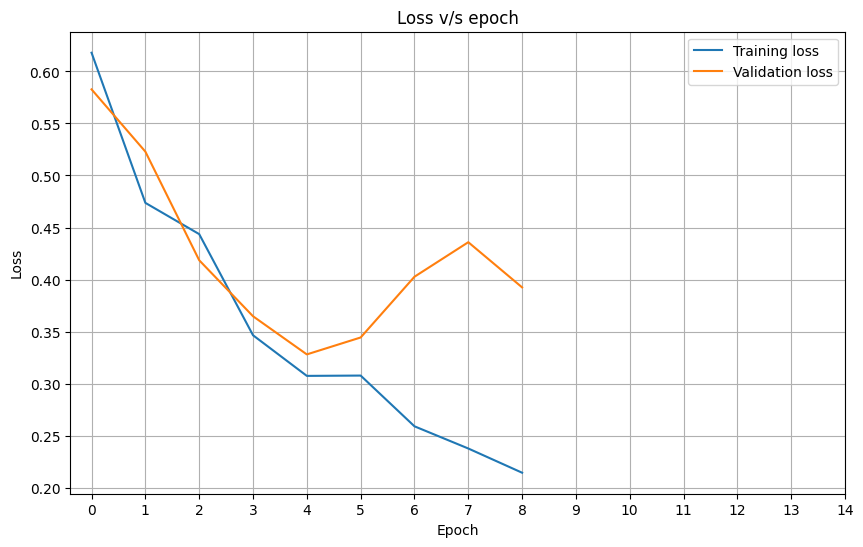

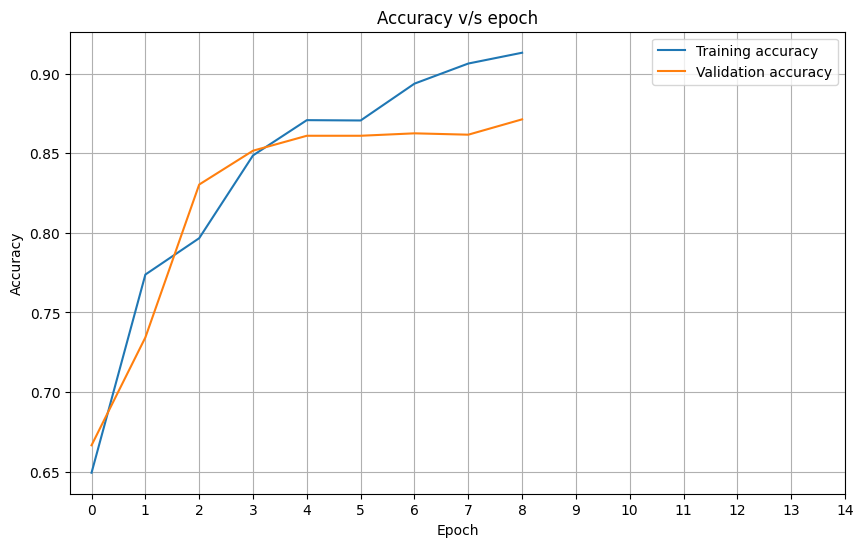

In [62]:
if __name__=='__main__':
  device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  #device=torch.device('cpu')
  params={'device':device,
          'epochs':15,
          'batchSize':512,
          'alpha':5e-4,
          'vocabularySize':len(vocabulary),
          'embDim':300,
          'hiddenDim':300,
          'lstmLayers':2,
          'bi':True,                          #whether bidirectional LSTM or not
          'opDim':len(trSet.unique('label')), #as there are two label classes - positive and negative - this is 2
          'rate':0.5,                         #drop-out rate
          'padIndex':idxPad,
          'unknownIndex':idxUnk
          }
  #Data iterators
  trIterator=dataIterators('train',trSet,params)
  valIterator=dataIterators('validate',valSet,params)
  tsIterator=dataIterators('test',tsSet,params)
  #Train the LSTM model
  model,costFun,metrics=train(vocabulary,trIterator,valIterator,params)
  print('Model training complete, and the model has {} learnable parameters.\n\n'.format(sum(weight.numel() for weight in model.parameters() if weight.requires_grad==True)))
  #Plot the learning curves
  figure1=plt.figure(figsize=(10,6))
  axis=figure1.add_subplot(1,1,1)
  axis.plot(metrics['train_losses'],label='Training loss')
  axis.plot(metrics['valid_losses'], label='Validation loss')
  axis.set_xticks(range(params['epochs']))
  axis.set_title('Loss v/s epoch')
  axis.set_xlabel('Epoch')
  axis.set_ylabel('Loss')
  axis.legend()
  axis.grid()
  figure2=plt.figure(figsize=(10,6))
  axis=figure2.add_subplot(1,1,1)
  axis.plot(metrics['train_accs'], label='Training accuracy')
  axis.plot(metrics['valid_accs'], label='Validation accuracy')
  axis.set_xticks(range(params['epochs']))
  axis.set_title('Accuracy v/s epoch')
  axis.set_ylabel('Accuracy')
  axis.set_xlabel('Epoch')
  axis.legend()
  axis.grid()

In [ ]:
#Evaluate the LSTM model
model.load_state_dict(torch.load('lstm.pt'))#equate model weights to that of the one with the best validation results
loss,accuracy=evaluate(model,tsIterator,costFun,params)
print(f'Testing loss: {loss:.3f},Testing accuracy: {accuracy:.3f}')